# Libraries

In [83]:
# -- Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# -- Model --
from xgboost import XGBRFRegressor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, Dataset
# -- Error Metrics --
from sklearn.metrics import mean_squared_error, r2_score
# -- Model Selection --
from sklearn.model_selection import train_test_split, cross_val_score
# -- Preprocessing --
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

XGBRFRegressor

xgboost.sklearn.XGBRFRegressor

Fix description of data

## Data Description

In [84]:
# Give names to the features
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_info = [ 
"(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" 
]

def name_sensor_data(sensor_info: list):
    '''Helper to describe sensor data and get column names'''
    sensor_dict = {}
    for i, sensor in enumerate(sensor_info):
        sensor_dict['s_'+ str(i + 1)] = sensor

    sensor_names = list(sensor_dict.keys())
    col_names = index_names + setting_names + sensor_names
    return sensor_dict, col_names

sensor_description, col_names = name_sensor_data(sensor_info)

In [85]:
df_train = pd.read_csv(r"C:\DATA\TIME-SERIES\turbofan-engine-dataset\CMaps\train_FD001.txt",
                       sep=r'\s+', header=None, index_col=False, names=col_names)
df_test = pd.read_csv(r"C:\DATA\TIME-SERIES\turbofan-engine-dataset\CMaps\test_FD001.txt",
                      sep=r'\s+', header=None, index_col=False, names=col_names)
y_valid = pd.read_csv(r"C:\DATA\TIME-SERIES\turbofan-engine-dataset\CMaps\RUL_FD001.txt",
                     sep=r'\s+', header=None, names=['RUL'])
print(f"Test Shape: {df_test.shape}\nTrain Shape:{df_train.shape}\nRUL Labels: {y_valid.shape}")
print(f"Percentage of the test-set: {len(df_test)/(len(df_train)+len(df_test))*100:.3f}%")

Test Shape: (13096, 26)
Train Shape:(20631, 26)
RUL Labels: (100, 1)
Percentage of the test-set: 38.829%


### Detect nulls and add RUL

In [86]:
def detect_null(dfs: list):
    results = []
    for i, df in enumerate(dfs):
        null_mask = df.isnull().any(axis=1)
        null_row_idx = np.where(null_mask)[0]
        null_counts = df.isnull().sum(axis=1)
        results.append((i, null_row_idx, null_mask, null_counts))
        print(f"Dataframe {i}:")
        print(f"|   Total tows with nulls: {len(null_row_idx)}")
        print(f"|   Total null values {df.isnull().sum().sum()}")
        if len(null_row_idx) > 0:
            print(f"  Rows with nulls: {null_row_idx.tolist()[:10]}")  
            if len(null_row_idx) > 10:
                print(f"  ... and {len(null_row_idx) - 10} more")
        else:
            print(f"|-->No null values detected!\n")

    return results

null_report = detect_null([df_train, df_test, y_valid])

Dataframe 0:
|   Total tows with nulls: 0
|   Total null values 0
|-->No null values detected!

Dataframe 1:
|   Total tows with nulls: 0
|   Total null values 0
|-->No null values detected!

Dataframe 2:
|   Total tows with nulls: 0
|   Total null values 0
|-->No null values detected!



In [87]:
def add_RUL(
        df, 
        unit_col='engine', 
        cycle_col='cycle', 
        rul_col='RUL', 
        clip_min=None
    ):
    max_cycles = df.groupby(unit_col)[cycle_col].transform('max')
    df[rul_col] = max_cycles - df[cycle_col]
    if clip_min is not None:
        df[rul_col] = df[rul_col].clip(lower=clip_min)
    return df

df_train = add_RUL(df_train)
df_train[['cycle','RUL']].head(5)

,cycle,RUL
0,1,191
1,2,190
2,3,189
3,4,188
4,5,187


In [88]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200


# Model Performance

In [89]:
from pprint import pp
def evaluate(
    y_true,
    y_pred,
    label: str = ''
):
    """Evaluation function"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    pp({
        "label": label,
        "RMSE": rmse,
        "R2": r2
    })

def plot_performance(
        y_true: float, 
        y_pred: float,
        # max_engines: int = 50,
        figsize: tuple = ((25,10))
    ):
    '''Visualization of predicted vs actual RUL'''
    
    fig, ax = plt.subplots(figsize=figsize)

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()


    indices = np.arange(len(y_true))
    bar_width = 0.35

    ax.bar(
        x=indices - bar_width / 2, 
        height=y_true,
        width=bar_width,
        color='#2ecc71',
        alpha=0.8,
        label='[True] RUL'
    )
    ax.bar(
        x=indices + bar_width / 2,
        height=y_pred,
        width=bar_width,
        color='#e74c3c',
        alpha = 0.8,
        label='[Pred] RUL',
    )
    
    # Showtime
    for i, (true, pred) in enumerate(zip(y_true, y_pred)):
        ax.plot(
            [i - bar_width / 2, i + bar_width / 2],
            [true, pred],
            color='#34495e',
            ls=':',
            alpha=0.6
        )
        
    ax.set_title('RUL Prediction Performance', fontsize=20, pad=20)
    ax.set_xlabel('Engine Index', fontsize=16)
    ax.set_ylabel('RUL (cycles)', fontsize=16)
    ax.set_xticks(indices)
    ax.legend(framealpha=1,)
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

## Clean data, no useless sensors and added rolling data

In [ ]:
drop_cols = [
    "setting_1",
    "setting_2",
    "setting_3",
    "cycle",
    "s_1", "s_5", "s_6","s_10", "s_16", "s_18", "s_19"
]

df_clean = df_train.drop(columns=drop_cols)
feature_columns = [col for col in df_clean.columns]

def calculate_rolling_mean(df, window=10):
    '''Calculates rolling features'''
    df = df.copy()

    sensor_cols = [c for c in df.columns if c.startswith("s_")]

    for sensor in sensor_cols:
        df[f"{sensor}_rm"] = (
            df.groupby("engine")[sensor]
              .transform(lambda x: x.rolling(window, min_periods=1).mean())
        )

    return df

df_rm = calculate_rolling_mean(df_clean)
sample_engine = df_rm[df_rm['engine'] == 1]
sample_engine[['s_17', 's_17_rm']].plot(figsize=(12,6))

In [ ]:
df_rm.drop(columns=["engine"], inplace=True)
X_clean = df_rm.drop(["RUL"], axis=1)
y_clean = df_rm["RUL"].clip(upper=130)
feature_columns = list(X_clean.columns)

sample_engine = X_clean[X_clean['u']]

In [100]:
def _get_sequences(
        X: pd.DataFrame, 
        y: pd.Series,
        SEQ_LEN: int
    ):
    X_np = np.array(X)
    y_np = np.array(y)
    X_seq, y_seq = [], []
    for i in range(len(X_np) - SEQ_LEN):
        X_seq.append(X_np[i:i+SEQ_LEN])
        y_seq.append(y_np[i+SEQ_LEN])
    X_seq = torch.tensor(X_seq, dtype=torch.float32)
    y_seq = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    return X_seq, y_seq



X_seq, y_seq = _get_sequences(X_clean,
                              y_clean,
                              SEQ_LEN=20)

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, shuffle=False
)

mean = X_train_seq.mean(dim=(0, 1), keepdim=True)  # (1, 1, F)
std  = X_train_seq.std(dim=(0, 1), keepdim=True) + 1e-8

X_train_seq = (X_train_seq - mean) / std
X_test_seq  = (X_test_seq  - mean) / std

def arr_to_tensor(data: np.ndarray | pd.DataFrame):
    '''Converts from pd.DataFrame/np.ndarray to torch.tensor'''
    if not isinstance(data, (pd.DataFrame, np.ndarray)):
        raise TypeError("data can't be converted to tensor")

    if isinstance(data, np.ndarray):
        return torch.tensor(data, dtype=torch.float32)
    if isinstance(data, pd.DataFrame):
        return torch.tensor(data.to_numpy(), dtype=torch.float32)


class LSTMRegressor(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 256,
        num_layers: int = 2,
        output_dim: int = 1,
        dropout_prob: float = 0.2
    ):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout_prob = dropout_prob

        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.dropout_prob if self.num_layers > 1 else 0.0,
            batch_first=True
        )

        self.head = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use last hidden state
        last_hidden = h_n[-1]   # (batch, hidden_dim)
        return self.head(last_hidden)

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, X_seq, y_seq):
        self.X = X_seq
        self.y = y_seq

        assert self.X.dim() == 3
        assert self.y.dim() == 2
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SequenceDataset(X_train_seq, y_train_seq)

train_loader = DataLoader(
    train_ds,
    batch_size=128,     
    shuffle=True,
    drop_last=True
)

model = LSTMRegressor(input_dim=28)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 200

history = []

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    mean_loss = total_loss / len(train_loader)
    history.append(mean_loss)

    if epoch % 10 == 0:
        print(f"> Epoch {epoch}/{epochs}, loss = {mean_loss:.4f}")


> Epoch 0/200, loss = 6435.5906
> Epoch 10/200, loss = 2289.0581


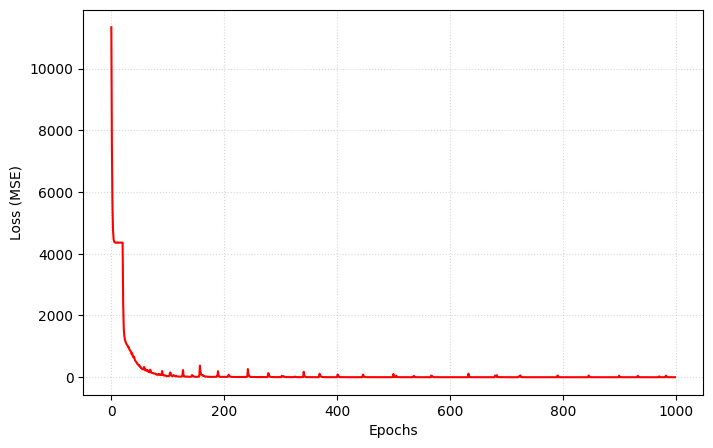

In [13]:
def plot_learning_curve(history: list[dict]):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(
        range(len(history)), 
        history,
        color='red'
    )
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.grid(axis='both', alpha=0.5, ls=':')
    plt.show()
plot_learning_curve(history)

In [14]:
checkpoint = {
    'model_state_dict': model.state_dict(),
    'input_dim': model.input_dim,
    'hidden_dim': model.hidden_dim,
    'num_layers': model.num_layers,
    'dropout_prob': model.dropout_prob, 
    'normalization_stats': {
        'mean': mean,  
        'std': std     
    }
}
torch.save(checkpoint, 'lstm_model_inference.pth')
print("Checkpoint saved correctly!")

Checkpoint saved correctly!


# Test Prediction

Model loaded successfully from checkpoint for testing.
{'label': 'LSTMRegressor',
 'RMSE': np.float64(51.750275984318435),
 'R2': 0.537142276763916}
None
Plotting performance for the first 80 test samples...


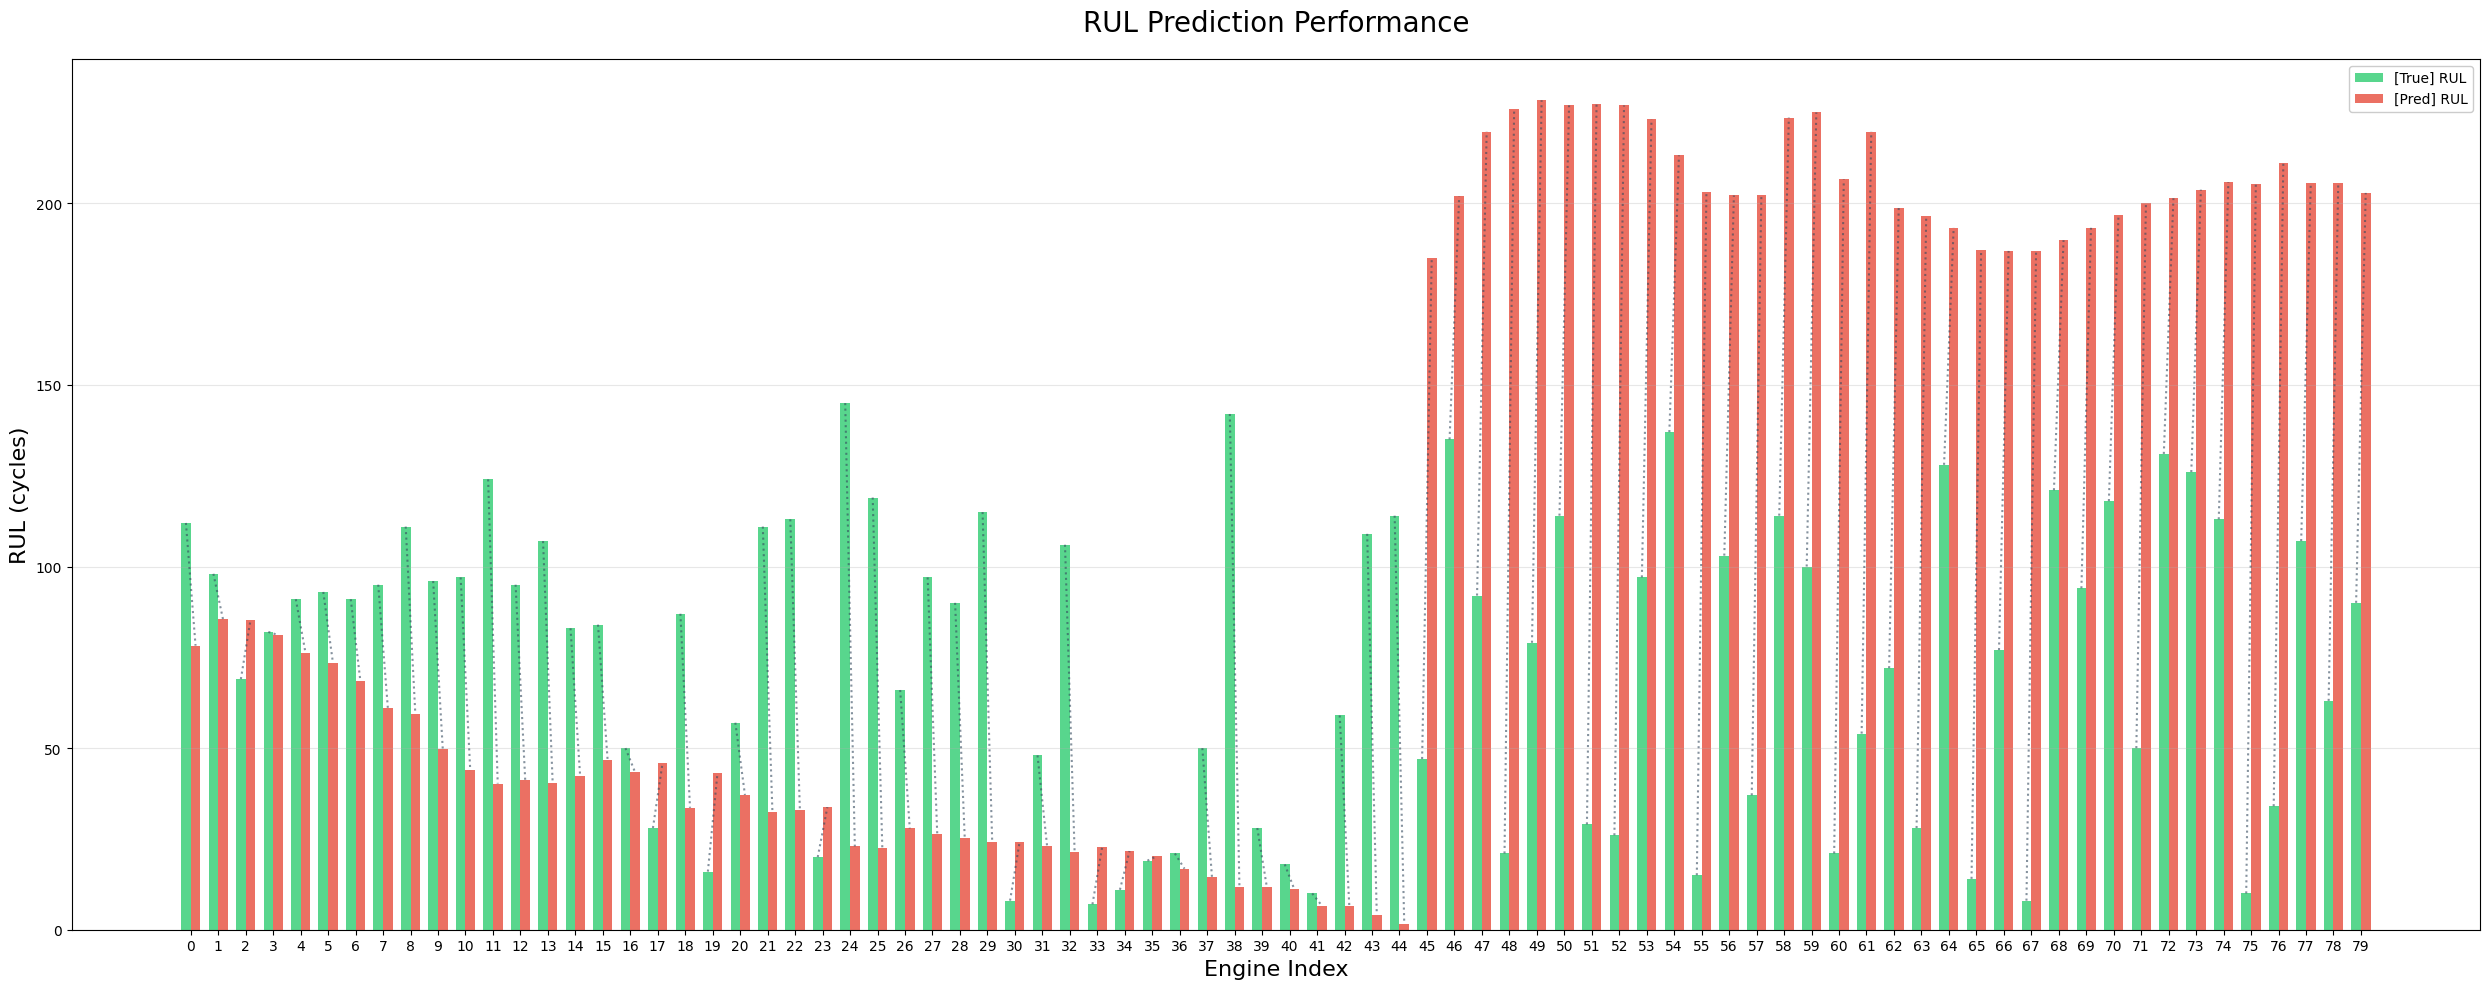

In [15]:
checkpoint_path = 'lstm_model_inference.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)

# Instantiate the model using the saved hyperparameters
model_for_testing = LSTMRegressor(
    input_dim=checkpoint['input_dim'],
    hidden_dim=checkpoint['hidden_dim'],
    num_layers=checkpoint['num_layers'],
    dropout_prob=checkpoint.get('dropout_prob', 0.2) # .get for backward compatibility
)

# Load the trained weights
model_for_testing.load_state_dict(checkpoint['model_state_dict'])

# This turns off dropout and other training-specific layers.
model_for_testing.eval()

print("Model loaded successfully from checkpoint for testing.")

# The test set `X_test_seq` is already normalized, so we can use it directly.
# Use torch.no_grad() to make predictions more efficient (no gradients needed)
with torch.no_grad():
    y_pred_tensor = model_for_testing(X_test_seq)

# Convert predictions and ground truth to NumPy arrays for plotting
# .cpu() is important if trained on a GPU
y_pred_np = y_pred_tensor.cpu().numpy()
y_true_np = y_test_seq.cpu().numpy()


print(evaluate(y_true_np, y_pred_np, type(model).__name__))

SAMPLES_TO_PLOT = 80

print(f"Plotting performance for the first {SAMPLES_TO_PLOT} test samples...")

plot_performance(
    y_true=y_valid[:SAMPLES_TO_PLOT], 
    y_pred=y_pred_np[:SAMPLES_TO_PLOT]
)

## Final valid testing

Shape of the final test sequences tensor: torch.Size([100, 20, 17])
Validation set: 
{'label': '', 'RMSE': np.float64(33.9208062072528), 'R2': 0.3336954116821289}
Plotting performance on the final hold-out test set...


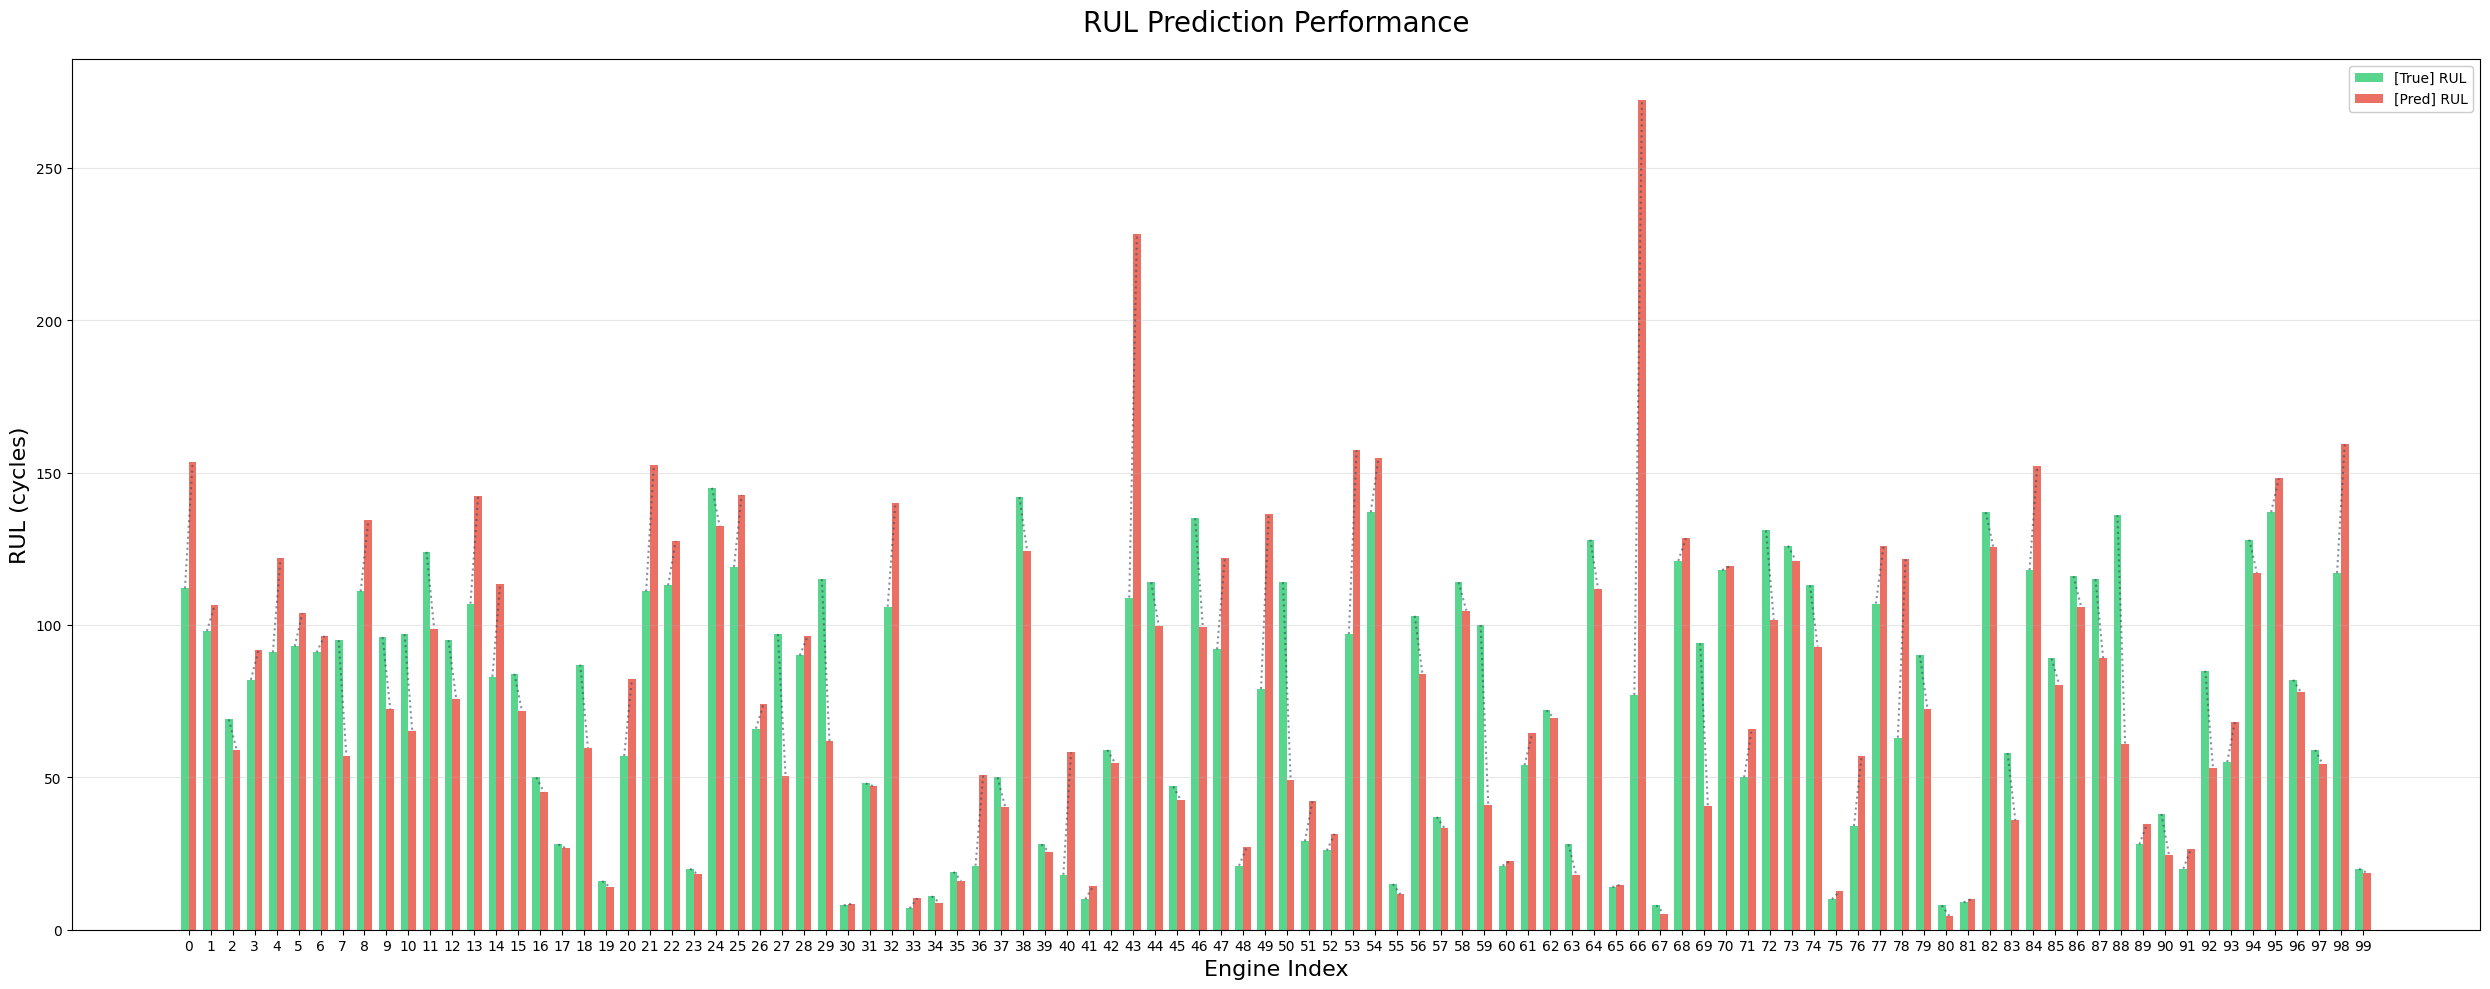

In [16]:
SEQ_LEN = 20 # The same sequence length you used for training

# We'll group the test data by engine and take the last SEQ_LEN cycles from each.
X_test_sequences = []
for engine_id in df_test['engine'].unique():
    # Get the data for the current engine
    engine_data = df_test[df_test['engine'] == engine_id]
    
    # Extract the features for that engine
    engine_features = engine_data[feature_columns]
    
    last_sequence = engine_features.tail(SEQ_LEN).to_numpy()
    
    X_test_sequences.append(last_sequence)

X_test_final_np = np.array(X_test_sequences)
X_test_final = torch.tensor(X_test_final_np, dtype=torch.float32)

print(f"Shape of the final test sequences tensor: {X_test_final.shape}")
# For FD001, this will be (100, 20, 17)

# Load the normalization stats from your saved checkpoint
checkpoint_path = 'lstm_model_inference.pth'
checkpoint = torch.load(checkpoint_path, weights_only=True)

mean = checkpoint['normalization_stats']['mean']
std = checkpoint['normalization_stats']['std']

# Apply the normalization
X_test_final_normalized = (X_test_final - mean) / std


# Make predictions on the final, prepared test set
with torch.no_grad():
    y_pred_final_tensor = model_for_testing(X_test_final_normalized)

# Convert predictions and ground truth to NumPy arrays
y_pred_final_np = y_pred_final_tensor.cpu().numpy()
y_true_final_np = y_valid.to_numpy() # y_valid is the RUL_FD001.txt data

print('Validation set: ')
evaluate(y_true_final_np, y_pred_final_np)

# Visualize the results using your plotting function
print("Plotting performance on the final hold-out test set...")
plot_performance(
    y_true=y_true_final_np, 
    y_pred=y_pred_final_np
)
